In [36]:
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
import pprint
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
from onnxmltools.utils import save_model
import onnxruntime as rt
import onnx
import pyomo.environ as pyo
from omlt.block import OmltBlock
from omlt.gbt import GBTBigMFormulation, GradientBoostedTreeModel
import omlt
import lightgbm as lgb
import onnxmltools.convert.lightgbm.convert

In [37]:
# df = pd.read_csv("..\OMLT_ML\data\polynomial3.csv")
# df.head()

# X = df["theta"]
# y = df["z"]

# X = X.to_numpy().reshape(-1, 1)
# y = y.to_numpy().reshape(-1, 1)

# X.shape, y.shape

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42)
# reg = GradientBoostingRegressor()
# reg.fit(X_train, y_train)
# reg.predict(X_test)
# reg.score(X_test, y_test)
# y_pred = reg.predict(X)

# # plotting results
# plt.scatter(X, y, label='z (original data)')
# plt.scatter(X, y_pred, label='z (sklearn)')
# plt.ylabel('z')
# plt.xlabel('theta')
# plt.legend()
# plt.show()


In [38]:
# initial_type = [('float_input', FloatTensorType([-1, 1]))]
# onx = convert_sklearn(reg, initial_types=initial_type)
# with open("./output/sklearn_boosting.onnx", "wb") as f:
#     f.write(onx.SerializeToString())

# sess = rt.InferenceSession("./output/sklearn_boosting.onnx")
# input_name = sess.get_inputs()[0].name
# print("input name", input_name)
# input_shape = sess.get_inputs()[0].shape
# print("input shape", input_shape)
# input_type = sess.get_inputs()[0].type
# print("input type", input_type)
# output_name = sess.get_outputs()[0].name
# print("output name", output_name)
# output_shape = sess.get_outputs()[0].shape
# print("output shape", output_shape)
# output_type = sess.get_outputs()[0].type
# print("output type", output_type)
# pred_onx = sess.run([output_name], {input_name: X.astype(np.float32)})
# # plotting results
# plt.scatter(X, y, label='z (original data)')
# plt.scatter(X, pred_onx, label='z (onnx)')
# plt.ylabel('z')
# plt.xlabel('theta')
# plt.legend()
# plt.show()

# model_onnx = onnx.load('./output/sklearn_boosting.onnx')
# # model_onnx

# onnx_model = onx


In [39]:
# f_bnds = [(float(min(X)), float(max(X))) for _ in range(1)]
# f_bnds

# opt_model = pyo.ConcreteModel()
# opt_model.gbt = OmltBlock()
# gbt_model = GradientBoostedTreeModel(onnx_model,
#                                      scaled_input_bounds=f_bnds)

# # omlt uses a big-m formulation to encode the tree models
# formulation = GBTBigMFormulation(gbt_model)
# opt_model.gbt.build_formulation(formulation)

In [40]:
# first dataset
df = pd.read_csv("../data/polynomial3.csv")
#retrieve input 'x' and output 'y' from the dataframe
x = df["theta"]
y = df["z"]
df['x'] = df["theta"]
df['y'] = df["z"]

In [41]:
# df = pd.read_csv("../data/sin_quadratic.csv", index_col=[0])
# x = df["x"]
# y = df["y"]

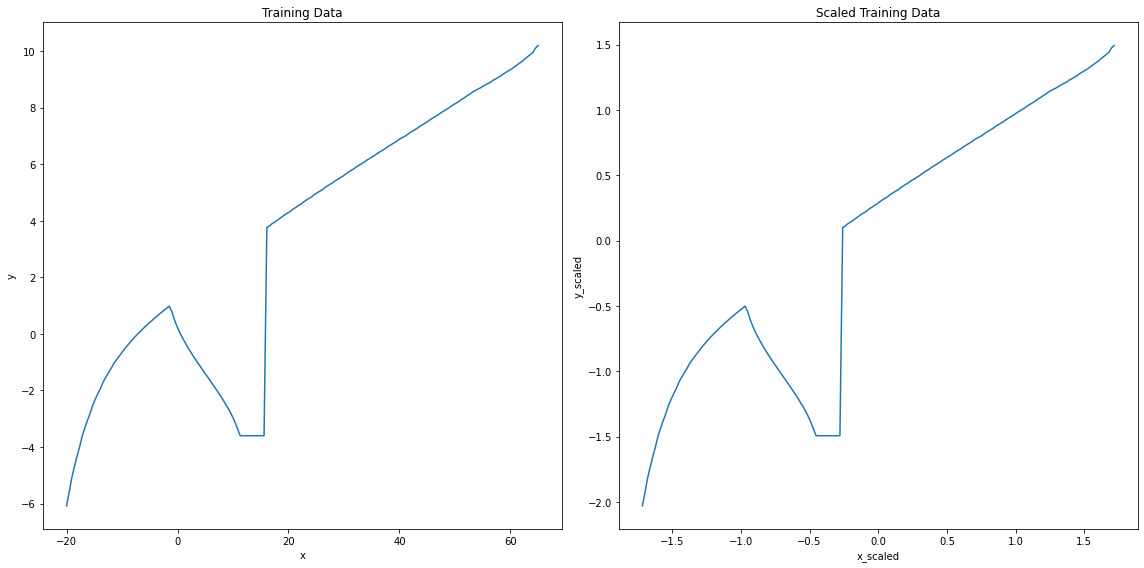

In [42]:
#calculate mean and standard deviation, add scaled 'x' and scaled 'y' to the dataframe
mean_data = df.mean(axis=0)
std_data = df.std(axis=0)
df["x_scaled"] = (df['x'] - mean_data['x']) / std_data['x']
df["y_scaled"] = (df['y'] - mean_data['y']) / std_data['y']

#create plots for unscaled and scaled data
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.plot(x, y)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("Training Data")

ax2.plot(df["x_scaled"], df["y_scaled"])
ax2.set_xlabel("x_scaled")
ax2.set_ylabel("y_scaled")
ax2.set_title("Scaled Training Data")

plt.tight_layout()


In [43]:
#Data needs to be in array and reshaped
x_scaled = df["x_scaled"].to_numpy().reshape(-1,1)
y_scaled = df["y_scaled"].to_numpy().reshape(-1,1)

In [44]:
#train the linear tree
regr = GradientBoostingRegressor()
history1 = regr.fit(x_scaled,y_scaled)

c:\Users\yufengq\anaconda3\envs\py39\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [45]:
#note: we calculate the unscaled output for each neural network to check the predictions
#nn1
y_predict_scaled_lt = regr.predict(x_scaled)
y_predict_lt = y_predict_scaled_lt * (std_data['y']) + mean_data['y']

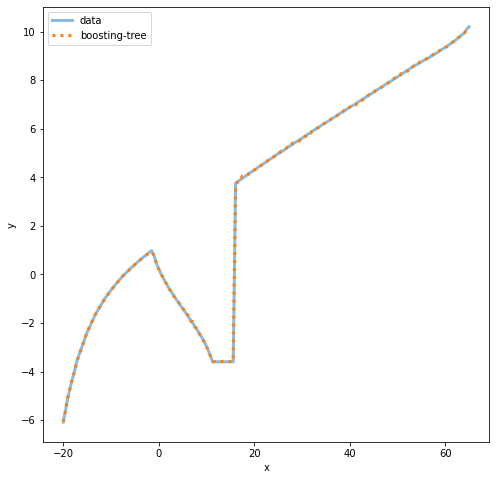

In [46]:
#create a single plot with the original data and each neural network's predictions
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.plot(x, y, linewidth=3.0, label="data", alpha=0.5)
ax.plot(x, y_predict_lt, linewidth=3.0,
        linestyle="dotted", label="boosting-tree")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()


In [47]:
#create an omlt scaling object
scaler = omlt.scaling.OffsetScaling(offset_inputs=[mean_data['x']],
                    factor_inputs=[std_data['x']],
                    offset_outputs=[mean_data['y']],
                    factor_outputs=[std_data['y']])

#create the input bounds. note that the key `0` corresponds to input `0` and that we also scale the input bounds
input_bounds={0:((min(df['x']) - mean_data['x'])/std_data['x'],
                 (max(df['x']) - mean_data['x'])/std_data['x'])};
print(scaler)
print("Scaled input bounds: ",input_bounds)

Scaled input bounds:  {0: (-1.7173848751853136, 1.7172339764407347)}


In [48]:
initial_type = [('float_input', FloatTensorType([-1, 1]))]
onnx_model = convert_sklearn(regr, initial_types=initial_type)

In [49]:
#create a GradientBoostedTreeModel Object
boostingmodel = GradientBoostedTreeModel(onnx_model,
                                         scaler, input_bounds)
#create a pyomo model with variables x and y
model1 = pyo.ConcreteModel()
model1.x = pyo.Var(initialize=0)
model1.y = pyo.Var(initialize=0)
model1.obj = pyo.Objective(expr=(model1.y))

#create an OmltBlock
model1.bt = OmltBlock()

#use the reduced-space formulation
formulation1_bt = GBTBigMFormulation(boostingmodel)
model1.bt.build_formulation(formulation1_bt)

#connect pyomo variables to the neural network
@model1.Constraint()
def connect_inputs(mdl):
    return mdl.x == mdl.bt.inputs[0]

@model1.Constraint()
def connect_outputs(mdl):
    return mdl.y == mdl.bt.outputs[0]

#solve the model and query the solution
status_1_bt = pyo.SolverFactory("gurobi", solver_io="python").solve(model1, tee=True)
solution_1_bt = (pyo.value(model1.x),pyo.value(model1.y))

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1958 rows, 951 columns and 6239 nonzeros
Model fingerprint: 0x10674cfa
Variable types: 787 continuous, 164 integer (164 binary)
Coefficient statistics:
  Matrix range     [2e-06, 5e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 7e+01]
  RHS range        [2e-16, 3e+00]
Presolve removed 352 rows and 205 columns
Presolve time: 0.14s
Presolved: 1606 rows, 746 columns, 5511 nonzeros
Variable types: 582 continuous, 164 integer (164 binary)
Found heuristic solution: objective -3.4019759

Root relaxation: objective -6.070560e+00, 195 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0

In [50]:
#print out model size and solution values
print("Reduced Space Solution:")
print("# of variables: ", model1.nvariables())
print("# of constraints: ", model1.nconstraints())
print("x = ", solution_1_bt[0])
print("y = ", solution_1_bt[1])
# print("Solve Time: ", status_1_bt['Solver'][0]['Time'])

Reduced Space Solution:
# of variables:  951
# of constraints:  1958
x =  -19.750002083667777
y =  -6.070560102426102


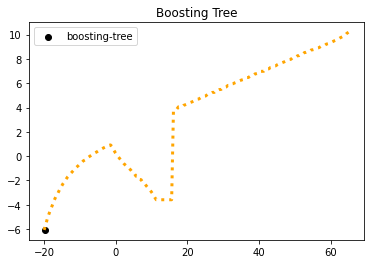

In [51]:
plt.plot(x, y_predict_lt,linewidth = 3.0,linestyle="dotted",color = "orange")
plt.title("Boosting Tree")
plt.scatter([solution_1_bt[0]],[solution_1_bt[1]],color = "black", label="boosting-tree")
plt.legend()

In [52]:
x_point = np.array((pyo.value(model1.x) -  mean_data['x']) / std_data['x']) 
y_point = regr.predict(x_point.reshape(-1, 1))
y_point = y_point * (std_data['y']) + mean_data['y']
y_point

array([-6.07056014])